In [1]:
import boto3
import pandas as pd
import numpy as np
import io

In [2]:
client = boto3.client("s3")
s3 = boto3.resource('s3')
path = 's3://saludmental/question.csv'

for bucket in s3.buckets.all():
    print(bucket.name)
    my_bucket = s3.Bucket(bucket.name)
    for file in my_bucket.objects.all():
        print(file.key)

saludmental
answer.csv
question.csv
survey.csv


In [3]:
obj = client.get_object(Bucket='saludmental', Key='question.csv')
response = obj['Body']
question = pd.read_csv(response)
print(question)

                                          questiontext  questionid
0                                    What is your age?           1
1                                 What is your gender?           2
2                         What country do you live in?           3
3    If you live in the United States, which state ...           4
4                               Are you self-employed?           5
..                                                 ...         ...
100  Do you think that team members/co-workers woul...         114
101  If yes, what condition(s) have you been diagno...         115
102  If maybe, what condition(s) do you believe you...         116
103  Which of the following best describes your wor...         117
104                              Do you work remotely?         118

[105 rows x 2 columns]


In [4]:
obj = client.get_object(Bucket='saludmental', Key='survey.csv')
response = obj['Body']
survey = pd.read_csv(response)
print(survey)

   SurveyID                    Description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019


In [5]:
obj = client.get_object(Bucket='saludmental', Key='answer.csv')
response = obj['Body']
answer = pd.read_csv(response)
print(answer)

                AnswerText  SurveyID  UserID  QuestionID
0                       37      2014       1           1
1                       44      2014       2           1
2                       32      2014       3           1
3                       31      2014       4           1
4                       31      2014       5           1
...                    ...       ...     ...         ...
236893               Other      2016    2689         117
236894             Support      2016    2690         117
236895  Back-end Developer      2016    2691         117
236896     DevOps/SysAdmin      2016    2692         117
236897               Other      2016    2693         117

[236898 rows x 4 columns]


## INICIO DE EDA

## Question table

In [6]:
question

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [7]:
print("El numero de preguntas en de las encuestas es de: ", len(question))

El numero de preguntas en de las encuestas es de:  105


# Survey table

In [8]:
survey

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


SurveyID representa el año de la encuesta realizada y sirve de ID.

## Answer table

In [9]:
answer

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [10]:
answer.UserID.nunique()

4218

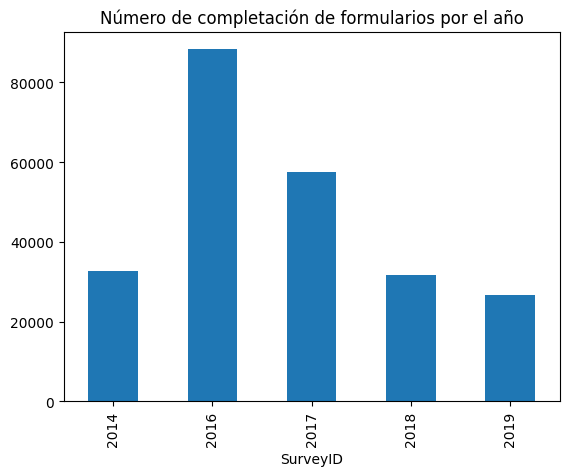

In [11]:
dist_survey = answer.groupby('SurveyID')['UserID'].count().plot.bar(title='Número de completación de formularios por el año')

In [12]:
df_join = pd.merge(answer,question,left_on='QuestionID', right_on='questionid')
df_join

,AnswerText,SurveyID,UserID,QuestionID,questiontext,questionid
0,37,2014,1,1,What is your age?,1
1,44,2014,2,1,What is your age?,1
2,32,2014,3,1,What is your age?,1
3,31,2014,4,1,What is your age?,1
4,31,2014,5,1,What is your age?,1
...,...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...,117
236894,Support,2016,2690,117,Which of the following best describes your wor...,117
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...,117
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...,117


In [13]:
df_join.dtypes

AnswerText      object
SurveyID         int64
UserID           int64
QuestionID       int64
questiontext    object
questionid       int64
dtype: object

In [14]:
question_1 = df_join[(df_join.questionid == 1)].sort_values(by='AnswerText', ascending=False).groupby('AnswerText')['SurveyID'].count().reset_index()
question_1 = question_1.astype({'AnswerText': 'int32'})
question_1 = question_1[ (question_1.AnswerText >= 18) & (question_1.AnswerText <= 100)]
question_1

,AnswerText,SurveyID
6,18,9
7,19,20
8,20,17
9,21,39
10,22,74
11,23,107
12,24,128
13,25,147
14,26,194
15,27,197


<AxesSubplot: title={'center': 'Dist de edades'}, xlabel='Edades', ylabel='Cantidad de personas'>

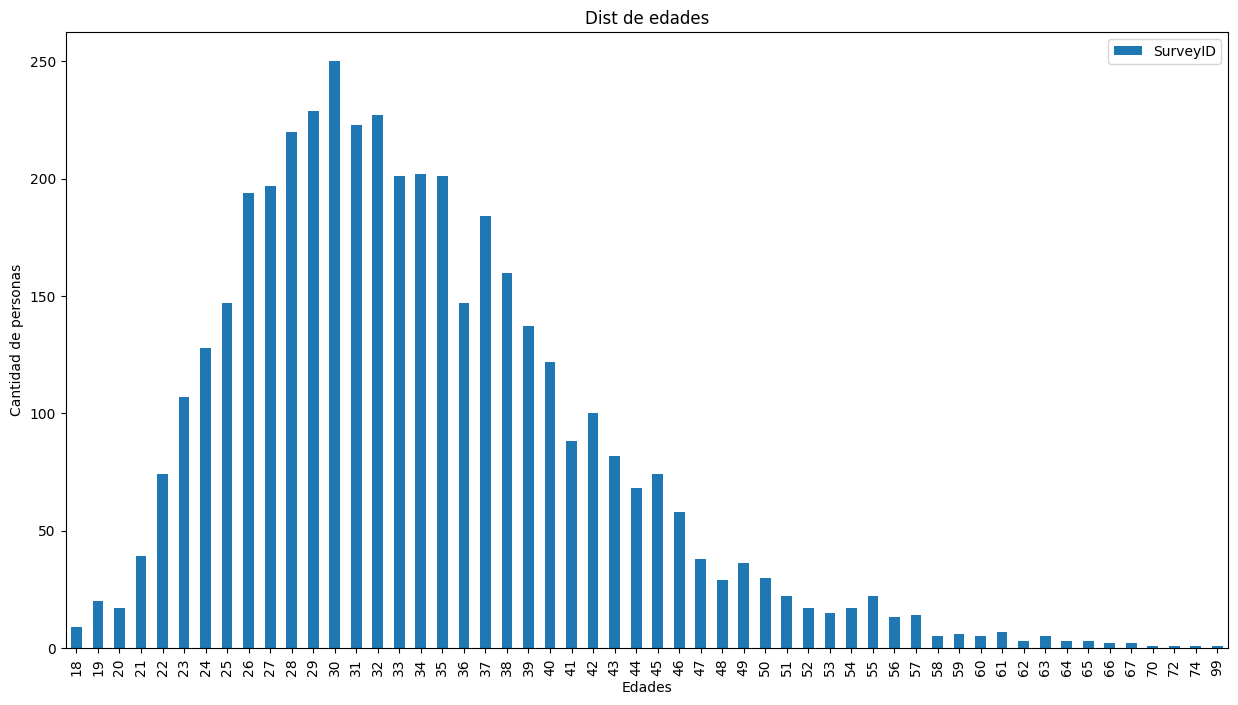

In [15]:
question_1.plot.bar(x='AnswerText', y='SurveyID', xlabel='Edades', ylabel='Cantidad de personas', title='Dist de edades', figsize=(15,8))

In [21]:
question_2 = df_join[(df_join.questionid == 118)].groupby('AnswerText')['SurveyID'].count().reset_index()
question_2

,AnswerText,SurveyID
0,Always,343
1,Never,333
2,Sometimes,757


<AxesSubplot: title={'center': 'Personas que prefieren trabajar de forma remota'}, xlabel='Respuesta', ylabel='Cantidad de personas'>

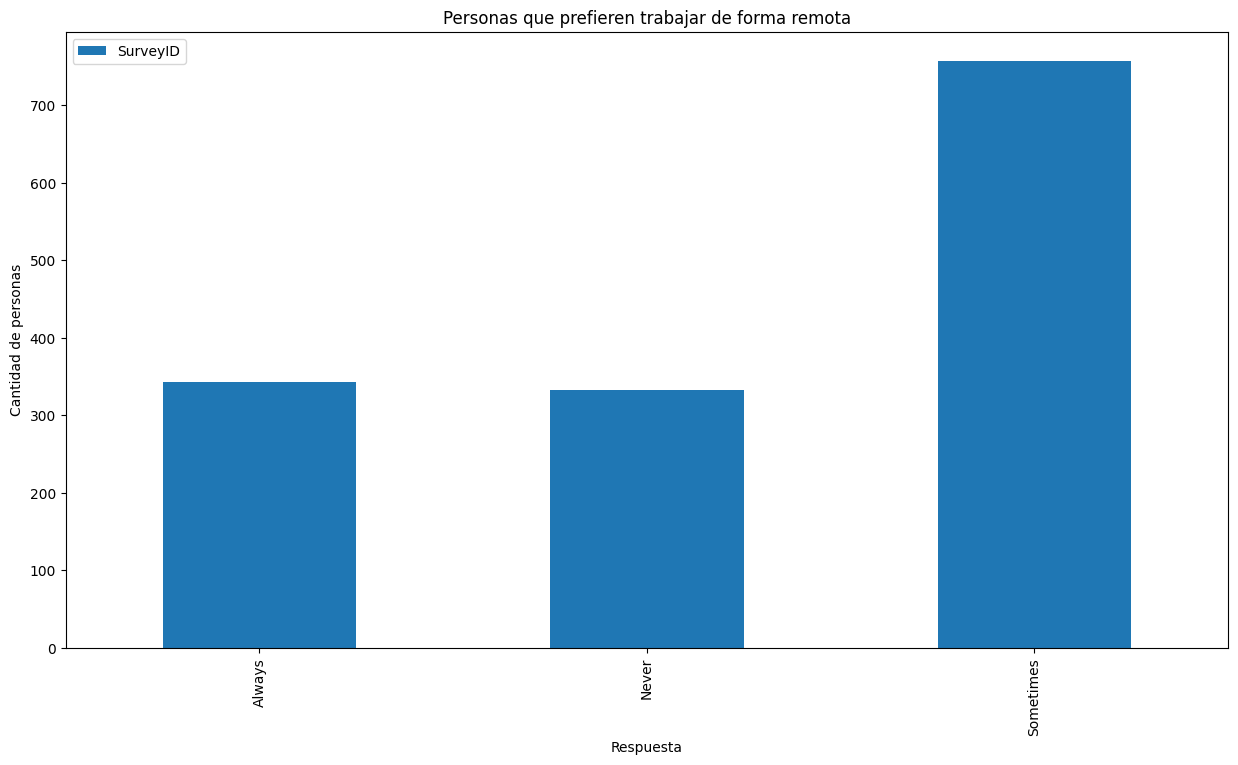

In [22]:
question_2.plot.bar(x='AnswerText', y='SurveyID', xlabel='Respuesta', ylabel='Cantidad de personas', title='Cantidad de personas que prefieren trabajar de forma remota', figsize=(15,8))
